### Common Imports

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Load the Data and Split into Train/Test Sets

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


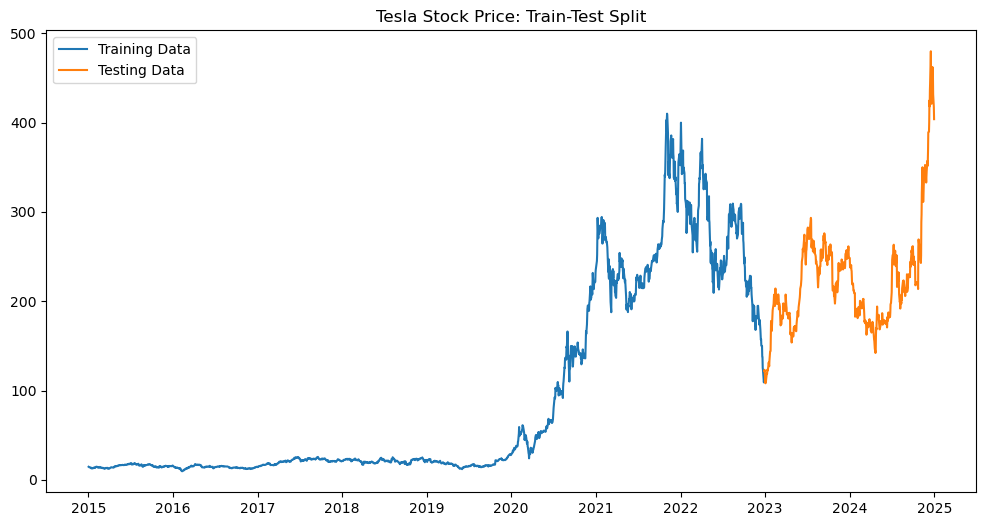

In [8]:
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split

# Load data from YFinance
tsla = yf.download("TSLA", start="2015-01-01", end="2025-01-01")
tsla = tsla[['Close']]  # Keep only the closing price

# Split into training and test sets (80% train, 20% test)
train_size = int(len(tsla) * 0.8)
train, test = tsla[:train_size], tsla[train_size:]

# Plot the train-test split
plt.figure(figsize=(12, 6))
plt.plot(train, label="Training Data")
plt.plot(test, label="Testing Data")
plt.legend()
plt.title("Tesla Stock Price: Train-Test Split")
plt.show()

### seasonality check 

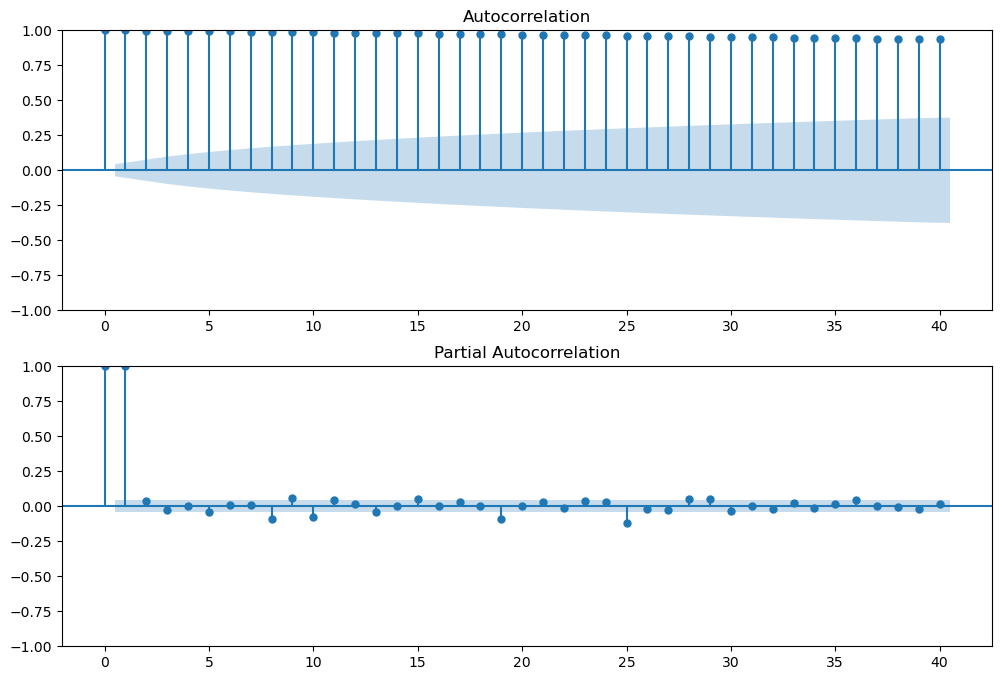

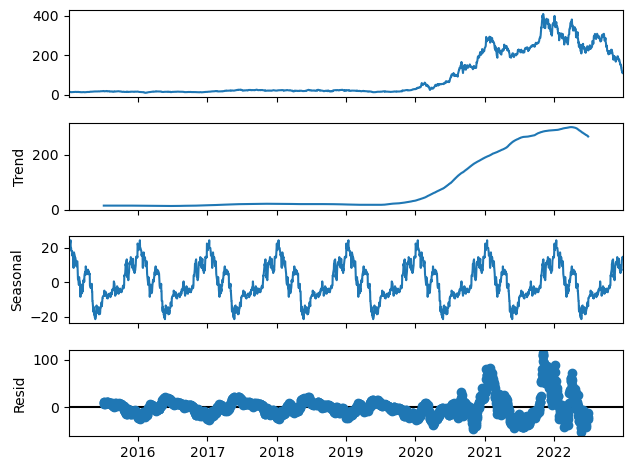

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# Plot Autocorrelation and Partial Autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train['Close'], lags=40, ax=ax[0])  # ACF (Autocorrelation Function)
plot_pacf(train['Close'], lags=40, ax=ax[1])  # PACF (Partial Autocorrelation Function)
plt.show()

# Decompose time series
decomposition = sm.tsa.seasonal_decompose(train['Close'], model='additive', period=252)  # Approx. 1 year of trading days
decomposition.plot()
plt.show()

### prepare merged data

In [4]:
import os
import pandas as pd

# Set the correct path to the 'data' folder from your working directory
data_folder = os.path.join(os.getcwd(), 'data')  # Relative path from 'notebooks' to 'data'

# List of file names
file_names = ["TSLA_data.csv", "BND_data.csv", "SPY_data.csv"]

# Load the datasets into a list of DataFrames
dfs = [pd.read_csv(os.path.join(data_folder, file)) for file in file_names]

# Clean the datasets
for i, df in enumerate(dfs):
    # Remove the first row that contains extra labels
    df.columns = df.iloc[1]  # Set the second row as the column headers
    df.drop([0, 1], inplace=True)  # Drop the first and second rows
    df.reset_index(drop=True, inplace=True)  # Reset the index

    # Convert the 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    # Print to check the cleaned data
    print(f"Data for {file_names[i]}:")
    print(df.head())

# Merge the dataframes on the 'Date' column
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = merged_df.merge(df, on="Date", how="inner")

# Check the merged data
print("Merged Data:")
print(merged_df.head())

# Save the merged data to a CSV file
merged_data_path = os.path.join(data_folder, 'merged_data.csv')
merged_df.to_csv(merged_data_path)

print(f'Merged data saved to: {merged_data_path}')

Data for TSLA_data.csv:
1                          NaN                 NaN                 NaN  \
Date                                                                     
2015-01-02  14.620667457580566  14.883333206176758   14.21733283996582   
2015-01-05  14.005999565124512  14.433333396911621  13.810667037963867   
2015-01-06  14.085332870483398  14.279999732971191   13.61400032043457   
2015-01-07  14.063332557678223    14.3186674118042  13.985333442687988   
2015-01-08  14.041333198547363   14.25333309173584  14.000666618347168   

1                          NaN       NaN  
Date                                      
2015-01-02  14.857999801635742  71466000  
2015-01-05  14.303333282470703  80527500  
2015-01-06  14.003999710083008  93928500  
2015-01-07  14.223333358764648  44526000  
2015-01-08  14.187333106994629  51637500  
Data for BND_data.csv:
1                          NaN                 NaN                 NaN  \
Date                                                       

### Train the XGBoost MODEL

In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

# Set the correct path to the 'data' folder from your working directory
data_folder = os.path.join(os.getcwd(), 'data')  # Relative path from 'notebooks' to 'data'

# Load the merged dataset from the 'data' folder
merged_data_path = os.path.join(data_folder, 'merged_data.csv')
df = pd.read_csv(merged_data_path, index_col=0)

# Check for missing values and drop them (or fill them, based on your preference)
df = df.dropna()  # This will drop rows with any NaN values

# Rename columns to simplify the names
df.columns = ['TSLA_Close', 'TSLA_High', 'TSLA_Low', 'TSLA_Open', 'TSLA_Volume', 
              'BND_Close', 'BND_High', 'BND_Low', 'BND_Open', 'BND_Volume', 
              'SPY_Close', 'SPY_High', 'SPY_Low', 'SPY_Open', 'SPY_Volume']

# Let's focus on predicting 'TSLA_Close' (you can change this to any column you want)
# Use other columns as features to predict TSLA_Close
X = df[['TSLA_Open', 'TSLA_High', 'TSLA_Low', 'BND_Close', 'BND_High', 'BND_Low', 'SPY_Close', 'SPY_High', 'SPY_Low']]
y = df['TSLA_Close']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 1.9365824599708095
Mean Squared Error (MSE): 12.207920275295619
Root Mean Squared Error (RMSE): 3.4939834394707168
